# Conditional Logic Demonstration Notebook

## Aims of Notebook

- Read accumulated I and Q data from a readout buffer and conditionally trigger a different pulse if I exceeds some threshold.

## To Do

- Remove AveragerProgram
- See if time between readout and second pulse may be reduced

In [ ]:
# Import libraries
%load_ext autoreload
%autoreload 2

%pylab inline

In [1]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [86]:
class ConditionalPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        gen_ch = cfg['gen_ch']
         
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=cfg['ro_ch'], freq=cfg["demod_freq"], length=cfg["readout_length"], gen_ch=cfg["gen_ch"])
            
        freq=self.freq2reg(cfg['pulse_freq'], gen_ch=gen_ch)  
  
        self.set_pulse_registers(ch=gen_ch, freq=freq, style=self.cfg['pulse_style'], phase=0, 
                                 gain=self.cfg['init_gain'], length=cfg['length'])
        self.synci(200) 
    
    def body(self):
        self.trigger(adcs=self.ro_chs, adc_trig_offset=self.cfg["adc_trig_offset"]) 
        self.pulse(ch=self.cfg['gen_ch']) 
        
        # the extra time in wait_all needs to be at least ~30, otherwise you will read a stale value corresponding to the previous readout
        # try a smaller value and you will see what I mean
        self.wait_all(30) #pause execution of commands until the end of the readout window, plus N cycles
        # the extra time here is optional? do whatever you need to get the timeline you want
        # if you are only running one rep and there are no more triggers or pulses, you don't even need a sync
        self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

        # it's important to only use registers that are not used elsewhere
        # some registers are used for averagerprogram/raveragerprogram counters, and each generator uses some registers for pulse parameters
        # we don't currently have a nice way to check which registers are unused (this is issue #19)
        # for now: page 0 registers 1-12 are not used
        self.read(self.cfg['gen_ch'], 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1
        self.read(self.cfg['gen_ch'], 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        self.memwi(0, 1, 123)
        self.memwi(0, 2, 124)


        self.condj(0, 1, '>', 0, "JUMP_LOC")
        self.pulse(ch=self.cfg['gen_ch'])
        self.label("JUMP_LOC")

In [116]:

config={"gen_ch":1, # --Fixed
        "reps":1, # --Fixed
        "pulse_style": "const", # --Fixed
        "length" : 200,
        "ro_ch":1, # --Fixed
        "init_gain":30000, # [DAC units]
        "pulse_freq": 50, # [MHz]
        'demod_freq': 0,
        "readout_length":50 , # 200
        "expts":1,
        "adc_trig_offset": 100+125, # 100 [Clock ticks]
        "soft_avgs":1
       }

prog =ConditionalPulse(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("sum of I and Q in decimated buffer:", [sum(iq) for iq in iq_list[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [-3921, 0]
sum of I and Q in decimated buffer: [188.0, 0.0]


-2845.0 2.0


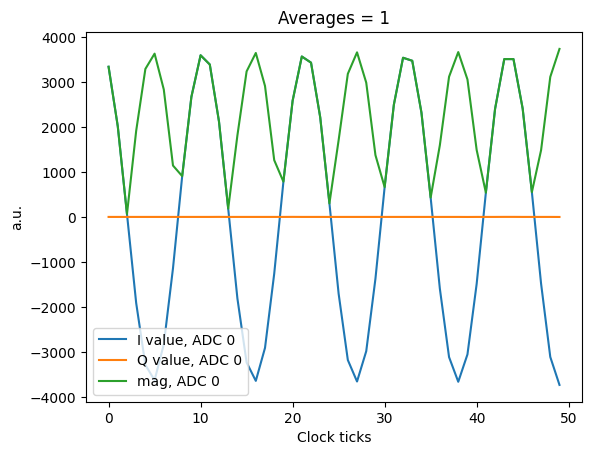

In [98]:
# Plot results.
plt.figure(1)
iq = iq_list[0]
plt.plot(iq[0], label="I value, ADC %d"%(config['ro_ch']))
plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_ch']))
plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))

print(sum(iq[0]), sum(iq[1]))

plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

In [25]:
iq_list = prog.acquire(soc, load_pulses=True, progress=True)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("I and Q values in accumulated buffer:", [iq*config['readout_length'] for iq in iq_list])


  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [-12427, -3]
I and Q values in accumulated buffer: [[array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54]), array([-248.54])], [array([

## BELOW CELL DOES NOT WORK

In [ ]:
prog = QickProgram(soccfg) # Create program object

prog.declare_gen(ch=1, nqz=1)
prog.set_pulse_registers(ch=1, gain=10000, freq=prog.freq2reg(100), phase=0, style="const", length=500)
prog.declare_readout(ch=1,length=100,freq=100,gen_ch=1)
# prog.pulse(ch=1, t=0)
prog.regwi(0,3,1)
prog.trigger(adcs=[1], t=400, adc_trig_offset=0, rp=0, r_out=3)
prog.waiti(0,1000)

# prog.read(1,0,"lower",3)
prog.regwi(0,2,1)
# prog.condj(0,2,'>',3,'after_reset')
prog.trigger(pins=[0], t=0, width=10)

prog.memwi(0, 3, 123)
# prog.label('after_reset')
prog.wait_all()
prog.end()

prog.config_all(soc) # Load assembly to board
soc.tproc.start() # Run program

time.sleep(0.1)

data = soc.tproc.single_read(addr=123)
print(data)

# print(prog)

32768
